### Normalized Nonlinear Fractional Schrödinger equation

\begin{equation}
    i \frac{\partial \psi}{\partial t} = \left[ \frac{1}{2} \left( - \frac{\partial^2}{\partial x^2}\right)^{\alpha/2} - \frac{|\psi|^2}{1 + s|\psi|^2} \right] \psi + V(x) \psi
\end{equation}

- Here, $\psi \equiv \psi(x,t)$ denotes the slowly varying complex amplitude of the light field. 
- The variables $t$, $x$, and $s$ represent the time, the normalized transverse coordinate, and the saturation parameter, respectively.

In [1]:
using FFTW, CairoMakie;  # Libraries for FFT and plotting

# Variables
N = 1000;  # Number of spatial points
tfinal = 5.0;  # Final time
dt = tfinal / 10000;  # Time step
M = Int(tfinal / dt);  # Total number of time steps
L = 50.0;  # Spatial domain length
x_grid = 20 * LinRange(-1, 1, N);  # Spatial grid
psi0 = exp.(-x_grid.^2);  # Initial wave function

# Fourier Transform Setup
Lx = N;  # Grid length
Lt = M;  # Total time steps
k = 2 * π * (fftshift(-Lx/2:Lx/2 - 1)) / (x_grid[end] - x_grid[1]);  # Wavenumbers

In [2]:
# Time evolution function
function time_evolution(psi, dt, k, g, s, V)
    """
    Evolves the wave function `psi` in time using the specified parameters.

    # Paramters
    - `psi`: The current wave function (complex array).
    - `dt`: Time step size (float).
    - `k`: Wavenumbers in Fourier space (vector).
    - `g`: Nonlinearity parameter (float).
    - `s`: Saturation parameter (float).
    - `V`: Potential term (float).

    # Returns
    - The evolved wave function after one time step (complex array).
    """
    psi_nonlinear = fft(exp.(-dt * 1im * ((g .* psi .* conj(psi)) ./ (1 .+ s .* psi .* conj(psi)) .+ V)) .* psi)
    psi_linear = ifft(exp.(-0.5 * dt * 1im * abs.(k).^alpha) .* psi_nonlinear)
    return psi_linear
end

time_evolution (generic function with 1 method)

In [3]:
psi = psi0 # Time evolution loop
alpha, g, s, V = 2, 0, 0, 0;  # Fractional order, nonlinearity, saturation, and potential

psi_evo = zeros(ComplexF64, N, M) # Initialize wave function evolution array
for t in 1:M
    psi = time_evolution(psi, dt, k, g, s, V)
    psi_evo[:, t] = psi
end

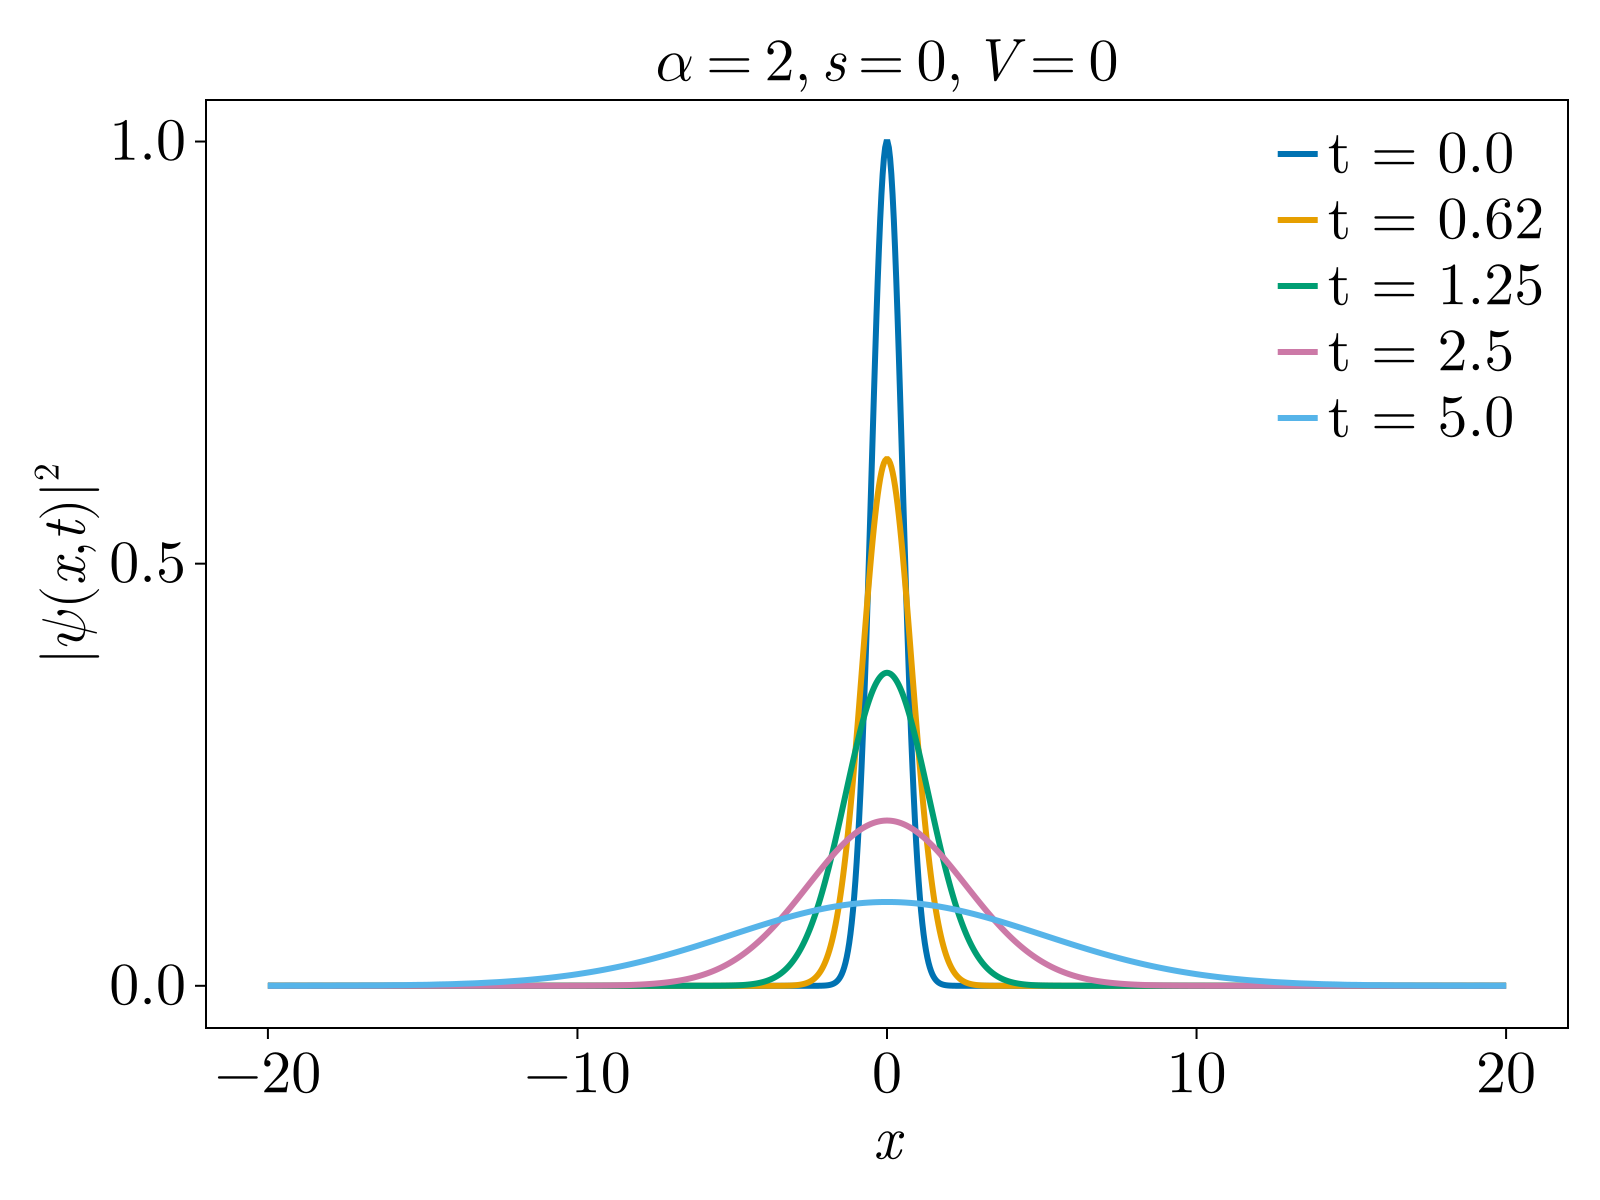

In [36]:
# Calculate |psi|^2
psi_final = real(psi_evo .* conj(psi_evo))

# Select time steps to plot
time_steps_to_plot = [1, Int(M/8), Int(M/4), Int(M/2), M]

# Plot results
# Set global theme
set_theme!(theme_latexfonts(), size = (800, 600))

fig = Figure(fontsize = 30)
ax = Axis(fig[1, 1], xlabel = L"x", ylabel = L"|\psi(x,t)|^2", xgridvisible = false, ygridvisible = false,
title = L"\alpha = 2,\, s = 0,\, V = 0")
for t in time_steps_to_plot
    lines!(ax, x_grid, psi_final[:, t], label="t = $(round(tfinal * t / M, digits=2))", alpha=1, linewidth=3)
end

axislegend(ax, framevisible = false)
save("./figs/lse_evolution.pdf", fig)
fig  # Display the plot

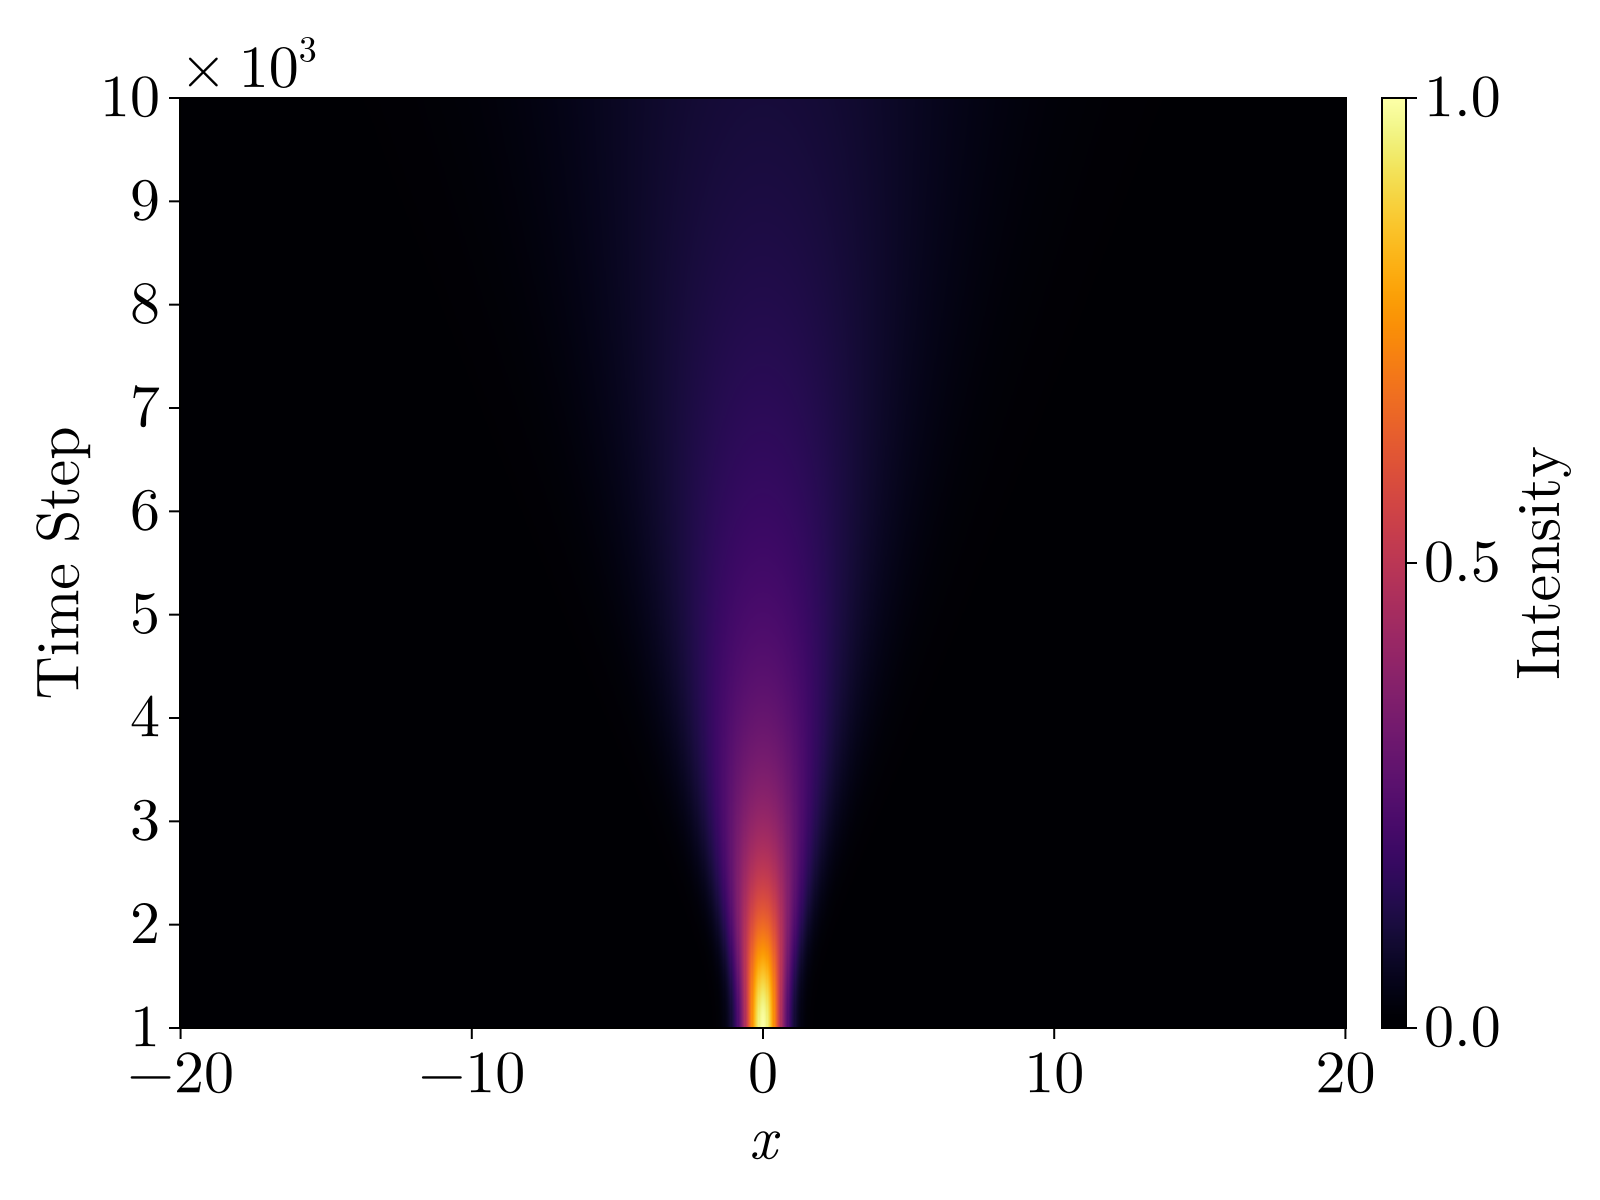

In [37]:
# Plot heatmap of the evolution of |psi|^2 over space and time
fig = Figure(fontsize=30)
ax = Axis(fig[1, 1], xlabel = L"$x$", ylabel = "Time Step")
y_scaled = 1:M/1000
heatmap!(ax, x_grid, y_scaled, psi_final, colormap = :inferno, rasterize = 1)
Label(fig[1, 1, Top()], halign = :left, L"\times 10^{3}")
# Add colorbar
Colorbar(fig[1, 2], colormap = :inferno, label = "Intensity")
save("./figs/lse_heatmap.pdf", fig)
fig  # Display the heatmap plot

### Exact Solution for Initial Gaussian wave packet

\begin{equation}
    \psi(x,t) = \frac{1}{\sqrt{1 + 2it}} \exp\left(- \frac{x^2}{1 + 2it}\right)
\end{equation}

In [8]:
# Exact analytical solution function for a Gaussian wave packet
function exact_solution(x, t)
    return 1 / sqrt(1 + 2im * t) * exp.(-x.^2 / (1 + 2im * t))
end

exact_solution (generic function with 1 method)

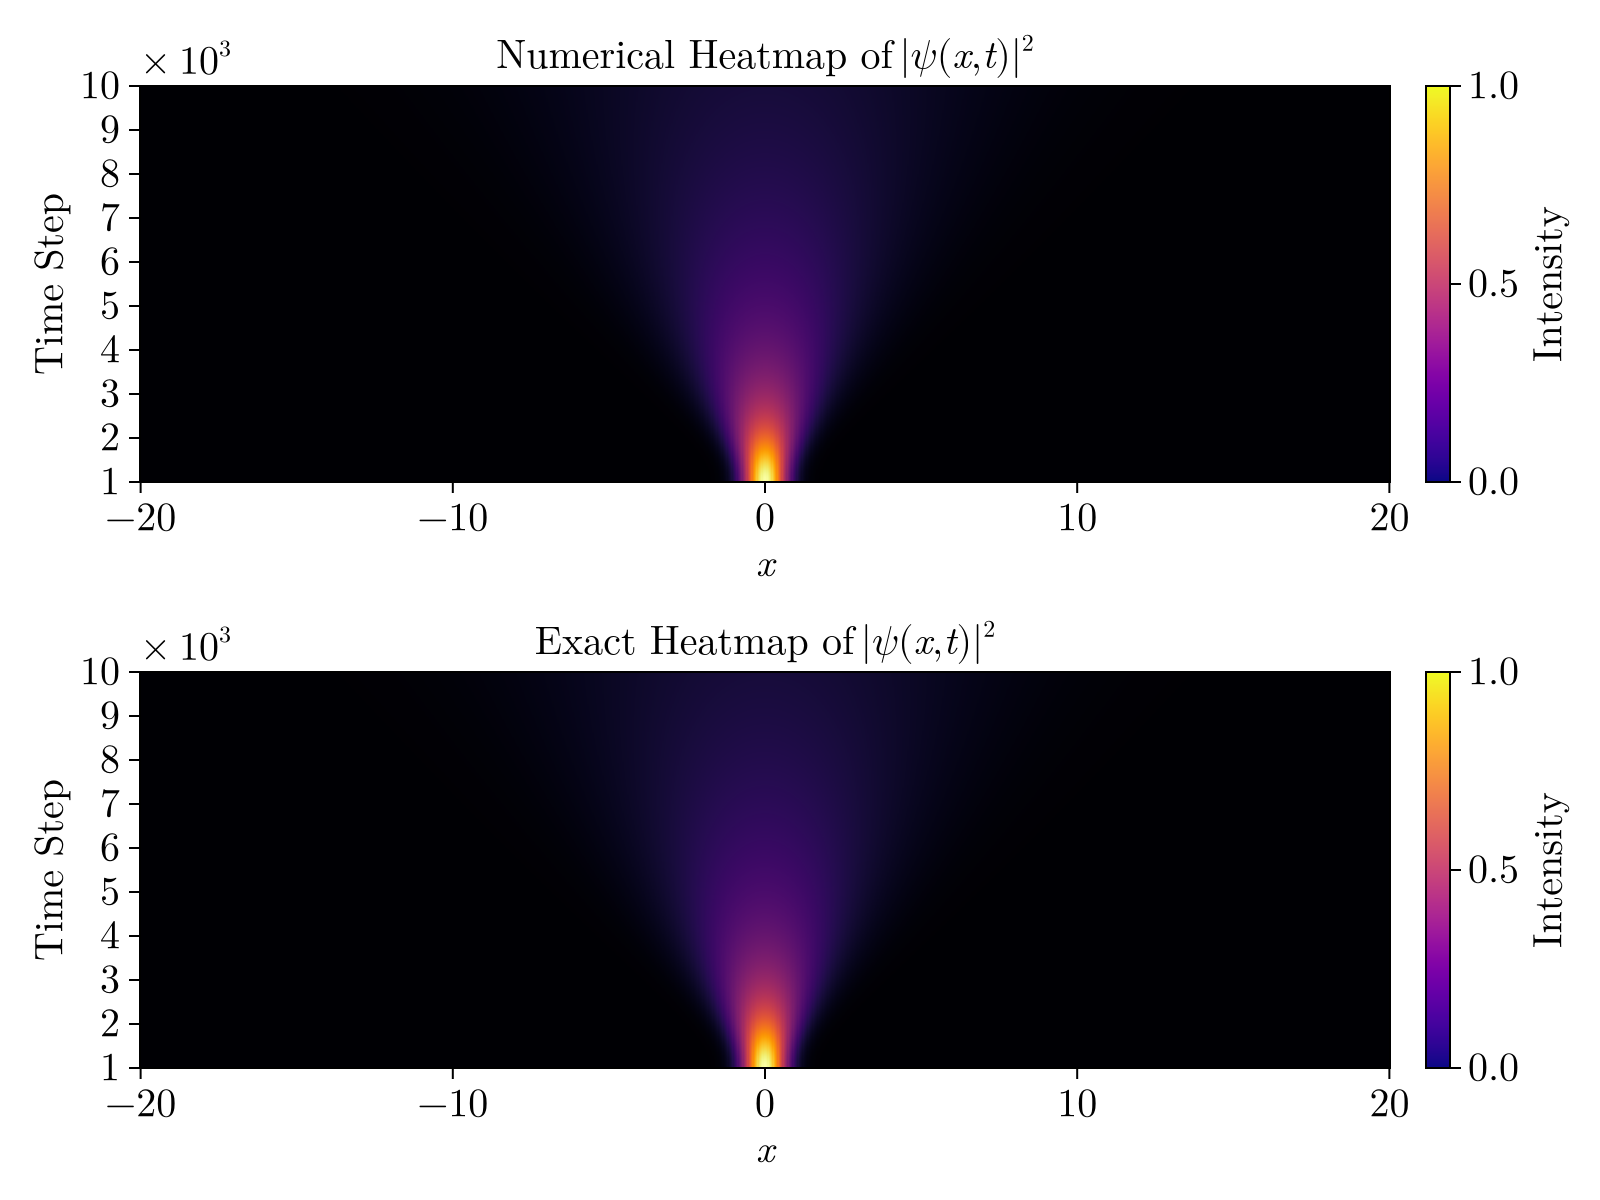

In [36]:
# Calculate exact solution at each time step
psi_exact = zeros(ComplexF64, N, M)
for t in 1:M
    time = t * dt
    psi_exact[:, t] = exact_solution(x_grid, time)
end

# Calculate |psi_exact|^2 for the exact solution
psi_exact_abs = real(psi_exact .* conj(psi_exact))

# Plot heatmap of the numerical and exact solution
fig = Figure(fontsize=20)

# Numerical solution heatmap
ax1 = Axis(fig[1, 1], xlabel = L"x", ylabel = "Time Step", title = L"\text{Numerical Heatmap of}\, |\psi(x,t)|^2")
heatmap!(ax1, x_grid, y_scaled, psi_final, colormap = :inferno, rasterize = 1)
Label(fig[1, 1, Top()], halign = :left, L"\times 10^{3}")
Colorbar(fig[1, 2], colormap = :plasma, label = "Intensity")

# Exact solution heatmap
ax2 = Axis(fig[2, 1], xlabel = L"x", ylabel = "Time Step", title = L"\text{Exact Heatmap of}\, |\psi(x,t)|^2")
heatmap!(ax2, x_grid, y_scaled, psi_exact_abs, colormap = :inferno, rasterize = 1)
Label(fig[2, 1, Top()], halign = :left, L"\times 10^{3}")
Colorbar(fig[2, 2], colormap = :plasma, label = "Intensity")
save("./figs/lse_comparison_heatmap.pdf", fig)
fig  # Display the heatmaps

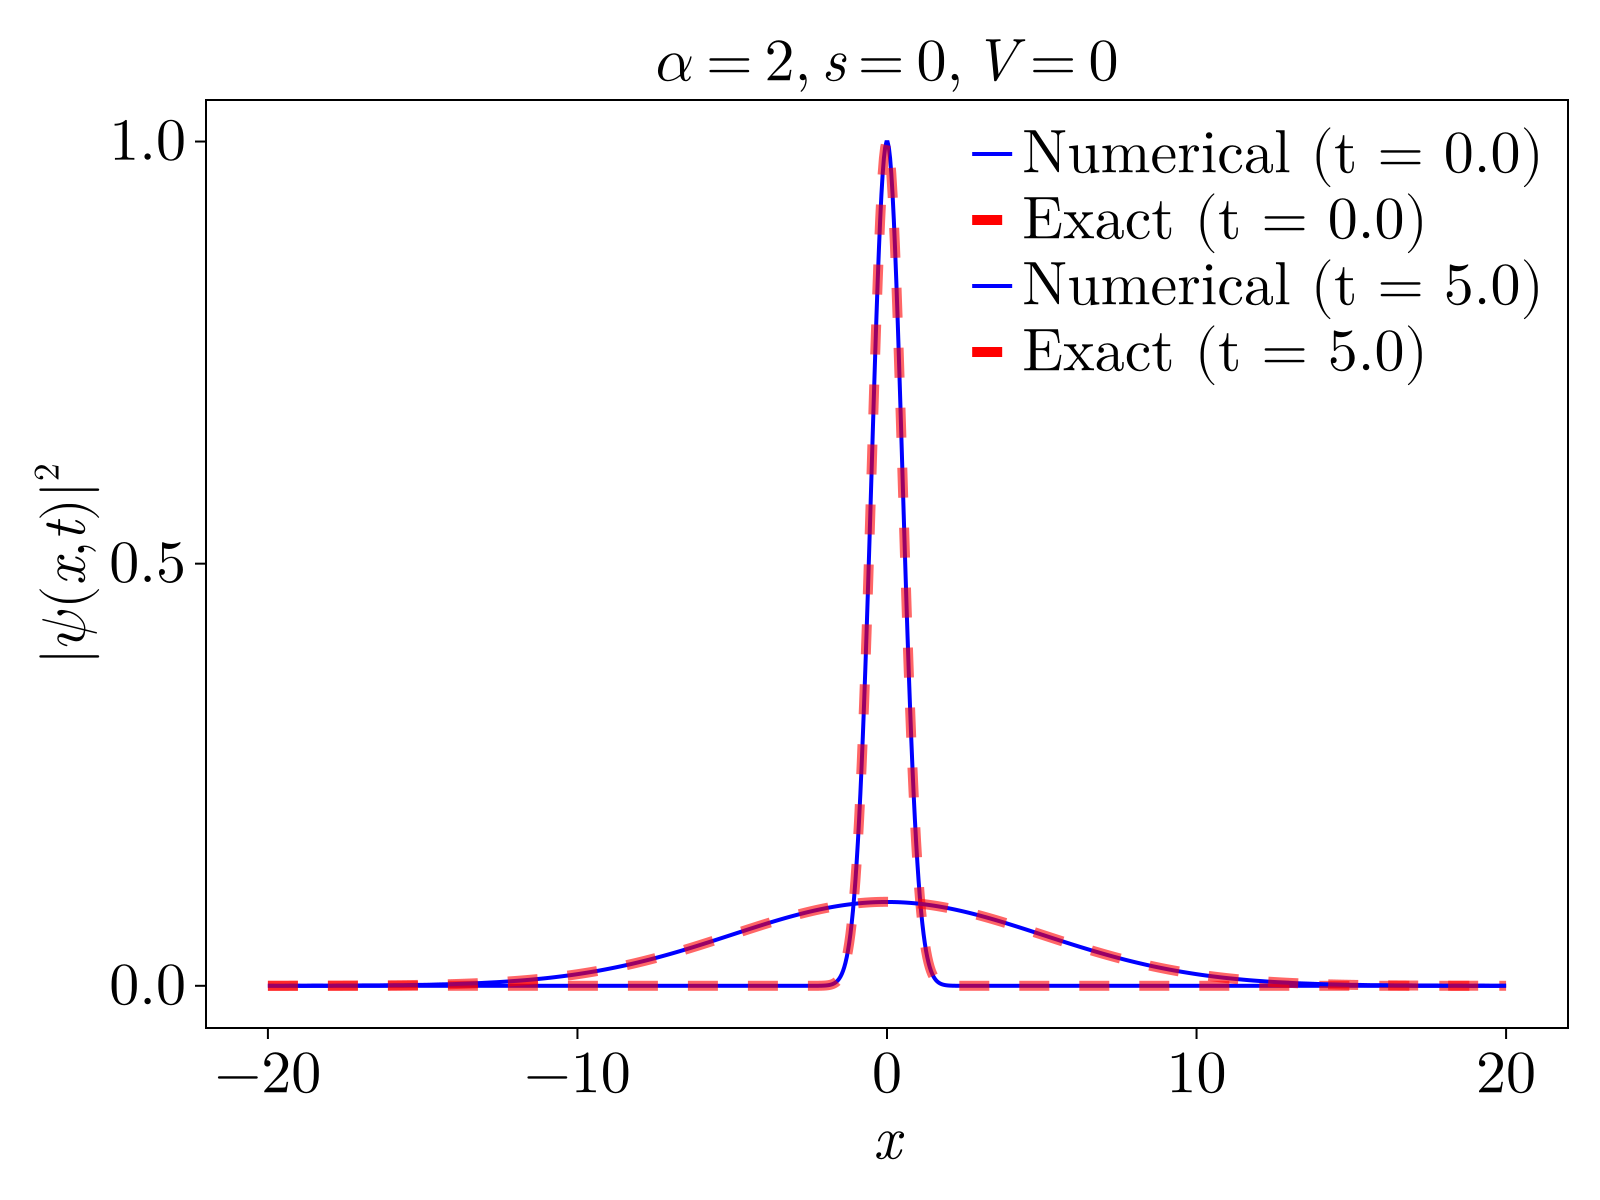

In [57]:
# Select specific time steps for comparison
time_steps_to_plot = [1, M]

# Plot line plots of the numerical and exact solution for selected time steps
fig = Figure(fontsize=30)
ax = Axis(fig[1, 1], xlabel = L"x", ylabel = L"|\psi(x,t)|^2", title = L"\alpha = 2,\, s = 0,\, V = 0", xgridvisible = false, 
ygridvisible = false)

# Plot numerical and exact solutions
for t in time_steps_to_plot
    time_value = round(tfinal * t / M, digits=2)
    
    # Plot numerical solution
    lines!(ax, x_grid, psi_final[:, t], label = "Numerical (t = $time_value)", color = :blue, linewidth=2, alpha=1)
    
    # Plot exact solution
    lines!(ax, x_grid, psi_exact_abs[:, t], label = "Exact (t = $time_value)", color = :red, linewidth=5, linestyle=:dash, alpha=0.6)
end
# Add a legend
axislegend(ax, position=:rt, framevisible=false)
save("./figs/lse_comparison_lineplot.pdf", fig)
fig  # Display the plot

### Soliton Solution for the Nonlinear Schrödinger Equation (NLSE)

\begin{equation}
    \psi(x,t) = A\ \text{sech}\left[A(x - vt)\right]\exp{\left[i \left(vx - \frac{v^2}{2}t + \theta\right)\right]}
\end{equation}

In [4]:
# Exact soliton solution function
function exact_soliton_solution(A, x, t, v)
    return A * sech.(A * (x .- v * t)) .* exp.(1im * (v * x .- 0.5 * v^2 * t))
end

exact_soliton_solution (generic function with 1 method)

In [5]:
A = 1  # Amplitude of the soliton
v = 0.0  # Velocity of the soliton (set to 0 for a stationary soliton)
g = 2.0  # Strength of the nonlinearity

# Soliton Initial Wave Function
psi0_soliton = A * sech.(A * x_grid) .* exp.(1im * v * x_grid);  # Soliton initial condition

alpha = 2.0  # Non-fractional (regular NLSE), so alpha = 2
V = 0.0  # No external potential
s = 0.0  # No saturation
